In [1]:
import io
import requests
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.widgets import Slider, Button, RadioButtons
import seaborn as sns
import PIL.Image as Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from sklearn.decomposition import PCA
from plotnine import *
from scipy import interp
from sklearn.base import TransformerMixin, BaseEstimator, clone
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.model_selection import learning_curve, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn import svm
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.pipeline import make_pipeline, FeatureUnion, Pipeline

pd.set_option('display.max_columns', None)  # 针对数据集中列比较多的情况，把dataframe中的列全部显示出来
pd.options.mode.chained_assignment = None

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 6.0)  # set default size of plots
#plt.rcParams['image.aspect'] = 1.3
plt.rcParams['image.interpolation'] = 'nearest'  # 设置 interpolation style
#plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['savefig.dpi'] = 300  #图片像素
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.size'] = 10
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.weight'] = 'normal'
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题
plt.rcParams['lines.markersize'] = 8
plt.rcParams['axes.spines.top'] = False
plt.rcParams[
    'axes.spines.right'] = False  #display only a left and bottom box border
plt.rcParams['legend.edgecolor'] = 'white'
plt.rcParams['axes.axisbelow'] = False
plt.rcParams['grid.color'] = 'white'
sns.set(style='white', palette=None, rc={"figure.figsize": (10, 6)})

# Preprocessing functions

In [2]:
def get_csv(url, timeout=100):
    r = requests.get(url, timeout=timeout)
    with io.BytesIO(r.content) as f:
        data = pd.read_csv(f)
    return data


def initial_exploration(DF, n_=100):
    print(DF.info())
    display(DF.head())
    display(DF.describe())
    if len(DF.select_dtypes(include=['object']).columns) > 0:
        display(DF.describe(include=['O']))


def convert_dtype(DF, cols, dtype):
    # convert DF columns to dtype
    # eg. float, int, bool, timedelta64, datetime64, category, etc
    for f in cols:
        DF[f] = DF[f].astype(dtype)
    #if dtype == 'category':
    #    DF[cols] = DF[cols].apply(lambda s: s.cat.codes.replace(
    #        {-1: len(s.cat.categories)}
    #    ))


def get_impute_grps(x, impute_grps):
    return impute_grps.iloc[impute_grps.index.isin([tuple(x)])].values.item()


def category_impute(DF, y_col, x_cols):
    impute_df = DF[x_cols + [y_col]]
    impute_grps = impute_df.groupby(x_cols).median()

    return impute_df[[y_col]].fillna(
        impute_df.reindex().loc[impute_df[y_col].isnull(), x_cols].apply(
            get_impute_grps, args=(impute_grps, ), axis=1))


def factorize_category(DF, cols=[None], ordinal=False):
    # factorize/discrete categorical/ordinal features
    if cols == [None]:
        cols = DF.columns
    cate_cols = DF[cols].select_dtypes(include=['category', 'object']).columns
    other_cols = list(set(cols) - set(cate_cols))
    assert len(cate_cols) > 0
    cate_DF = DF[cate_cols]

    if ordinal:
        result_DF = pd.get_dummies(cate_DF, prefix_sep='_', drop_first=False)
    else:
        for cate_col in cate_cols:
            keys = DF[cate_col].cat.categories.values.tolist()
            values = range(len(keys))
            cate_DF.loc[:, cate_col] = DF[cate_col].map(dict(zip(keys, values)))
            result_DF = cate_DF
            
    return pd.concat([DF[other_cols], result_DF], axis=1)


def randomforest_impute(DF, y_col, x_cols, classifier=True):
    impute_df = factorize_category(DF[x_cols])
    impute_df = pd.concat([impute_df, DF[[y_col]]], axis=1)
    
    impute_y = impute_df.loc[impute_df[y_col].notnull(), y_col].values
    impute_X = impute_df.loc[impute_df[y_col].notnull(), x_cols].values
    target_X = impute_df.loc[impute_df[y_col].isnull(), x_cols].values

    if classifier:
        rf = RandomForestClassifier(random_state=0, n_estimators=2000, n_jobs=-1)
    else:
        rf = RandomForestRegressor(random_state=0, n_estimators=2000, n_jobs=-1)
    rf.fit(impute_X, impute_y)
    impute_df.loc[impute_df[y_col].isnull(), y_col] = rf.predict(target_X)
    return impute_df[[y_col]]

# EDA functions (exploratory data analysis)

## cate vs. cate relationship

In [3]:
def stat_cat(DF, x, groups=[], pct_axis=0):
    # statistics of categorical features
    # x: a column name
    # groups: a list of column names
    if len(groups) == 0:
        count = DF[x].value_counts().fillna(0)
        percent = np.round(count * 100 / sum(count), 2)
        result = pd.concat([count, percent], axis=1)
        result.columns.values[-1] = x + '%'
    else:
        count = DF.groupby(groups)[x].value_counts().unstack().fillna(
            0).rename(columns=str).apply(lambda x: x.astype(np.int64))
        percent = count.apply(
            lambda x: x * 100 / sum(x),
            axis=pct_axis).apply(lambda x: np.round(x, 2)).rename(columns=str)
        #count = count
        result = pd.concat([count, percent], axis=1)
        result.columns.values[-count.shape[1]:] = [
            x + '%' for x in list(map(str, count.columns.values))
        ]
        #.reset_index()
    return result


def rel_cat_cat(DF,
                x,
                hue=None,
                col=None,
                row=None,
                pct=True,
                pct_axis=0,
                plot=False):
    # explore the relationship (barplot) between two
    # categorical columns: x, hue(feature, optional),
    # col(feature, optional), row(feature, optional)
    # with two options to return percentage/count results
    sel = list(set([x, hue, col, row]))
    if pd.Series(sel).isin([None]).sum() > 0:
        sel.remove(None)
    plot_DF = DF[sel]
    groups = list(set(sel) - set([x]))

    result = stat_cat(plot_DF, x, groups, pct_axis)

    if pct:
        plotdata = result.iloc[:, int(result.shape[1] / 2):]
    else:
        plotdata = result.iloc[:, :int(result.shape[1] / 2)]

    if plot:
        if len(groups) == 0:
            plotdata = plotdata.reset_index()
            g = sns.catplot(
                data=plotdata,
                x='index',
                y=plotdata.columns.values[-1],
                kind='bar',
                palette='deep')
        else:
            plotdata = plotdata.stack().reset_index()
            g = sns.catplot(
                data=plotdata,
                hue=hue,
                col=col,
                row=row,
                x=x,
                y=0,
                kind='bar',
                palette='deep')

        if pct:
            ylabel = 'Percentage'
        else:
            ylabel = 'Count'
        (g.set_axis_labels(
            x, ylabel).despine(left=True).set_xticklabels(rotation=30))

    return result

## continuous vs. cate relationship

In [4]:
def rel_cont_cat_hist(DF, x, col=None, row=None, bins=20, logtransform=False):
    # explore the relationship (histplot) between y and one/two
    # categorical columns: col(feature, optional), row(feature, optional)
    # with two options to log2 transform x
    sel = list(set([x, col, row]))
    if pd.Series(sel).isin([None]).sum() > 0:
        sel.remove(None)
    plot_DF = DF[sel]
    
    if logtransform:
        plot_DF.loc[:, x] = plot_DF[x].apply(lambda x: np.log2(x + 1))
    
    g = sns.FacetGrid(plot_DF, col=col, row=row)
    g.map(plt.hist, x, bins=bins)

In [5]:
def rel_cont_cat_point(DF, y, x, hue=None, col=None, row=None, logtransform=False):
    # explore the relationship (barplot) between y and two/three
    # categorical columns: x, col(feature, optional), row(feature, optional)
    # with two options to log2 transform y
    sel = list(set([y, x, hue, col, row]))
    if pd.Series(sel).isin([None]).sum() > 0:
        sel.remove(None)
    plot_DF = DF[sel]
    
    if logtransform:
        plot_DF.loc[:, y] = plot_DF[y].apply(lambda x: np.log2(x + 1))
    
    g = sns.FacetGrid(plot_DF, hue=hue, col=col, row=row)
    g.map(sns.pointplot, x, y, order=train_df[x].cat.categories)
    g.add_legend()

## continuous vs. continuous relationship

In [6]:
def rel_cont_cont_scatter(DF, y, x, hue=None, col=None, row=None, logtransform=False):
    # explore the relationship (barplot) between y and two/three
    # categorical columns: x, col(feature, optional), row(feature, optional)
    # with two options to log2 transform y
    sel = list(set([y, x, hue, col, row]))
    if pd.Series(sel).isin([None]).sum() > 0:
        sel.remove(None)
    plot_DF = DF[sel]
    
    if logtransform:
        plot_DF.loc[:, y] = plot_DF[y].apply(lambda x: np.log2(x + 1))
    
    g = sns.FacetGrid(plot_DF, hue=hue, col=col, row=row)
    g.map(sns.scatterplot, x, y)
    g.add_legend()

## plot_PCA

In [7]:
def PCA_exploration(X, y, feature_type):
    pca = PCA(n_components=2)  #PCA(n_components='mle') #
    pca.fit(X)
    print(pca.explained_variance_ratio_)
    f = lambda x: round(x, 1)

    features_r = pca.fit(X).transform(X)
    features_r = pd.DataFrame(features_r, columns=["PC1", "PC2"])
    features_r = features_r.applymap(f)
    features_r = pd.concat(
        [features_r, pd.DataFrame(y, columns=["target"])], axis=1)
    display(features_r.head())
    plt.figure(figsize=(10, 6))
    sns.stripplot(x="PC1", y="PC2", hue="target", data=features_r)
    plt.xticks(rotation=45)

    components = pd.DataFrame(pca.components_.T, columns=["PC1", "PC2"])
    components = components.applymap(f)
    components = pd.concat([
        components,
        pd.DataFrame(X.columns, columns=["featurenames"]),
        pd.DataFrame(feature_type, columns=["type"])
    ],
                           axis=1)
    display(components.head())
    '''plt.figure(figsize=(10, 6))
    ax = sns.lmplot(
        'PC1',  # Horizontal axis
        'PC2',  # Vertical axis
        data=components,  # Data source
        fit_reg=False,  # Don't fix a regression line
    )  # size and dimension

    plt.title('Example Plot')
    plt.xlabel('PC1')
    plt.ylabel('PC2')

    def label_point(x, y, val, ax):
        a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
        for i, point in a.iterrows():
            ax.text(point['x'] + .02, point['y'] + .02, str(point['val']))

    label_point(components.PC1, components.PC2, components.featurenames,
                plt.gca())
    '''
    display((ggplot(
        components, aes(x='PC1', y='PC2', color='type')
    ) + geom_point(size=5) + theme(
        legend_box_background=element_rect(
            fill=None, color='white', size=None, linetype=None, colour='white')
    ) + theme(
        text=element_text(
            family='Arial',
            face="plain",
            colour="black",
            size=18,
            angle=0,
            lineheight=0.9)) + theme(axis_line=element_line(size=1)) + theme(
                legend_background=element_rect(color='white', fill='white')) +
             theme(
                 panel_background=element_rect(color='white', fill='white'),
                 panel_grid_minor=element_line(None),
                 panel_grid_major=element_line(color='', size=1),
                 panel_ontop=True) + theme(figure_size=(9, 6))) +
            geom_text(
                aes(label='featurenames'), ha='left', va='bottom', size=16))

    return components

## plot_learning_curve

In [8]:
def plot_learning_curve(estimator,
                        title,
                        X,
                        y,
                        ylim=None,
                        cv=None,
                        n_jobs=1,
                        train_sizes=np.linspace(.05, 1., 20),
                        verbose=0,
                        plot=True):
    # 用sklearn的learning_curve得到training_score和cv_score
    """
    画出data在某模型上的learning curve.
    参数解释
    ----------
    estimator : 分类器。
    title : 标题。
    X : 输入的feature，numpy类型
    y : 输入的target vector
    ylim : tuple格式的(ymin, ymax), 设定图像中纵坐标的最低点和最高点
    cv : 做cross-validation的时候，数据分成的份数，其中一份作为cv集，其余n-1份作为training(默认为5份)
    n_jobs : 并行的的任务数(默认1)
    """
    train_sizes, train_scores, test_scores = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        verbose=verbose)

    learning_data = pd.concat([
        pd.DataFrame({
            'train_sizes': list(train_sizes) * cv
        }),
        pd.DataFrame({'train':train_scores.flatten(order='F')}),
        pd.DataFrame({'cross_val':test_scores.flatten(order='F')})
    ],
                              axis=1)
    learning_data = learning_data.melt(
        id_vars=['train_sizes'],
        value_vars=learning_data.columns[1:],
        var_name='scores_type',
        value_name='scores')

    if plot:
        g = sns.lineplot(
            x="train_sizes",
            y="scores",
            hue="scores_type",
            style="scores_type",
            data=learning_data,
            markers=True,
            dashes=False)
        display(g)

    largest_scores = learning_data[
        learning_data.train_sizes == learning_data.train_sizes.max()].groupby(
            'scores_type').agg([np.mean, np.std]).scores  #lambda x: np.std(x, doof=0)
    return (
        largest_scores.loc['train', 'mean'] + largest_scores.
        loc['train', 'std'] + largest_scores.loc['cross_val', 'mean'] -
        largest_scores.loc['cross_val', 'std']
    ) / 2, largest_scores.loc['train', 'mean'] + largest_scores.loc[
        'train', 'std'] - largest_scores.loc[
            'cross_val', 'mean'] + largest_scores.loc['cross_val', 'std']

## plot_ROC_curve

In [9]:
def plot_ROC_curve(clf, cv, X, y):
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    plt.figure(figsize=(12, 6))
    i = 0
    for train, test in cv.split(X, y):
        probas_ = clf.fit(X[train], y[train]).predict_proba(X[test])
        #probas_ = clf.fit(X[train], y[train]).decision_function(X[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

        i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")

# Estimators

## ColumnSelector

In [10]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)

        try:
            return X[self.columns]
        except KeyError:
            cols_error = list(set(self.columns) - set(X.columns))
            raise KeyError(
                "The DataFrame does not include the columns: %s" % cols_error)

## TypeSelector

In [11]:
class TypeSelector(BaseEstimator, TransformerMixin):
    def __init__(self, dtype):
        self.dtype = dtype

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X.select_dtypes(include=[self.dtype])

## Imputer

In [12]:
class ImputerContinous(BaseEstimator, TransformerMixin):
    # impute continous features
    def __init__(self, y_col, x_cols=[None], imputer='simple'):
        # available imputers: simple, category, randomforest
        self.imputer = imputer
        self.x_cols = x_cols
        self.y_col = y_col

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        sel = self.x_cols + [self.y_col]
        sel = filter_column(sel)
        assert len(list(set(sel) - set(X.columns))) == 0
        y_in_x = ~pd.Series(self.y_col).isin(self.x_cols)
        assert y_in_x.bool()
        impute_df = X[sel]

        if self.imputer == 'category':
            assert len(sel) > 1
            return category_impute(X, self.y_col, self.x_cols)
        elif self.imputer == 'randomforest':
            assert len(sel) > 1
            #return impute_df
            return randomforest_impute(
                impute_df, self.y_col, self.x_cols, classifier=False)
        elif self.imputer == 'simple':
            return pd.Series(
                SimpleImputer(strategy='median').fit_transform(
                    X[self.y_col].values.reshape(-1, 1)).flatten())
        else:
            print("Imputer method: %s is unavailable!" % self.imputer)


class ImputerCategory(BaseEstimator, TransformerMixin):
    # impute continous features
    def __init__(self, y_col, x_cols=[None], imputer='simple'):
        # available imputers: simple, category, randomforest
        self.imputer = imputer
        self.x_cols = x_cols
        self.y_col = y_col

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        sel = self.x_cols + [self.y_col]
        sel = filter_column(sel)
        assert len(list(set(sel) - set(X.columns))) == 0
        y_in_x = ~pd.Series(self.y_col).isin(self.x_cols)
        assert y_in_x.bool()
        impute_df = X[sel]

        if self.imputer == 'category':
            assert len(sel) > 1
            return category_impute(X, self.y_col, self.x_cols)
        elif self.imputer == 'randomforest':
            assert len(sel) > 1
            return randomforest_impute(impute_df, self.y_col, self.x_cols)
        elif self.imputer == 'simple':
            return pd.DataFrame(
                SimpleImputer(strategy='most_frequent').fit_transform(
                    X[self.y_col].astype('object').values.reshape(
                        -1, 1)).flatten(),
                columns=[sel])
        else:
            print("Imputer method: %s is unavailable!" % self.imputer)

## Binning

In [13]:
def filter_column(cols):
    # remove None and duplicate elements from cols
    if pd.Series(cols).isin([None]).sum() > 0:
        cols.remove(None)
    cols = set(cols)
    if len(cols) == 1:
        return [next(iter(cols))]
    else:
        return list(cols)


class Binning(BaseEstimator, TransformerMixin):
    # impute continous features
    def __init__(self, x_col, y_col=None, bins=5, retorders=True):
        self.x_col = x_col
        self.y_col = y_col
        self.bins = bins
        self.retorders = retorders

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        sel = [self.x_col, self.y_col]
        sel = filter_column(sel)
        assert len(list(set(sel) - set(X.columns))) == 0
        bin_df = X[sel].copy()
        
        bin_df[self.x_col + '_Bands'] = pd.cut(
                bin_df[self.x_col], self.bins, retbins=False)
        bin_df[self.x_col + '_BandsOrder'], Bins = pd.cut(
                bin_df[self.x_col], self.bins, labels=False, retbins=True)
        self.Bins = Bins
        
        if self.y_col == None:
            display(rel_cat_cat(bin_df, self.x_col + '_Bands', pct_axis=1))
        else:
            display(
                rel_cat_cat(
                    bin_df, self.x_col + '_Bands', hue=self.y_col, pct_axis=1))
        
        if self.retorders:
            return bin_df[[self.x_col + '_BandsOrder']]
        else:
            return bin_df[[self.x_col + '_Bands']]

## Todummies

In [14]:
class ToDummies(BaseEstimator, TransformerMixin):
    """ A Dataframe transformer that provide dummy variable encoding
    """
    
    def transform(self, X, **transformparams):
        """ Returns a dummy variable encoded version of a DataFrame
        
        Parameters
        ----------
        X : pandas DataFrame
        
        Returns
        ----------
        trans : pandas DataFrame
        
        """
    
        trans = pd.get_dummies(X).copy()
        return trans

    def fit(self, X, y=None, **fitparams):
        """ Do nothing operation
        
        Returns
        ----------
        self : object
        """
        return self

## DataFrameFunction

In [15]:
class DataFrameFunction(BaseEstimator, TransformerMixin):
    """ A DataFrame transformer providing imputation or function application
    
    Parameters
    ----------
    impute : Boolean, default False
        
    func : function that acts on an array of the form [n_elements, 1]
        if impute is True, functions must return a float number, otherwise 
        an array of the form [n_elements, 1]
    
    """
    
    def __init__(self, func, impute = False):
        self.func = func
        self.impute = impute
        self.series = pd.Series() 

    def transform(self, X, **transformparams):
        """ Transforms a DataFrame
        
        Parameters
        ----------
        X : DataFrame
            
        Returns
        ----------
        trans : pandas DataFrame
            Transformation of X 
        """
        
        if self.impute:
            trans = pd.DataFrame(X).fillna(self.series).copy()
        else:
            trans = pd.DataFrame(X).apply(self.func).copy()
        return trans

    def fit(self, X, y=None, **fitparams):
        """ Fixes the values to impute or does nothing
        
        Parameters
        ----------
        X : pandas DataFrame
        y : not used, API requirement
                
        Returns
        ----------
        self  
        """
        
        if self.impute:
            self.series = pd.DataFrame(X).apply(self.func).copy()
        return self

## DataFrameStandardScaler

In [16]:
class DataFrameStandardScaler(BaseEstimator, TransformerMixin):
    def transform(self, X, **transformparams):
        df = pd.DataFrame(X).copy()
        return pd.DataFrame(
            preprocessing.StandardScaler().fit_transform(df.values),
            index=df.index,
            columns=df.columns)

    def fit(self, X, y=None, **fitparams):
        return self

## DataFrameFeatureUnion

In [17]:
class DataFrameFeatureUnion(BaseEstimator, TransformerMixin):
    """ A DataFrame transformer that unites several DataFrame transformers
    
    Fit several DataFrame transformers and provides a concatenated
    Data Frame
    
    Parameters
    ----------
    list_of_transformers : list of DataFrameTransformers
        
    """ 
    def __init__(self, list_of_transformers):
        self.list_of_transformers = list_of_transformers
        
    def transform(self, X, **transformparamn):
        """ Applies the fitted transformers on a DataFrame
        
        Parameters
        ----------
        X : pandas DataFrame
        
        Returns
        ----------
        concatted :  pandas DataFrame
        
        """
        
        concatted = pd.concat([transformer.transform(X)
                            for transformer in
                            self.fitted_transformers_], axis=1).copy()
        return concatted


    def fit(self, X, y=None, **fitparams):
        """ Fits several DataFrame Transformers
        
        Parameters
        ----------
        X : pandas DataFrame
        y : not used, API requirement
        
        Returns
        ----------
        self : object
        """
        
        self.fitted_transformers_ = []
        for transformer in self.list_of_transformers:
            fitted_trans = clone(transformer).fit(X, y=None, **fitparams)
            self.fitted_transformers_.append(fitted_trans)
        return self

# EDA

## Load datasets

In [18]:
train =  get_csv(
    'https://raw.githubusercontent.com/cystanford/Titanic_Data/master/train.csv'
)
test = get_csv(
    'https://raw.githubusercontent.com/cystanford/Titanic_Data/master/test.csv'
)

In [19]:
initial_exploration(train)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Sivic, Mr. Husein",male,347082,G6,S
freq,1,577,7,4,644


In [20]:
initial_exploration(test)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB
None


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


,Name,Sex,Ticket,Cabin,Embarked
count,418,418,418,91,418
unique,418,2,363,76,3
top,"Corbett, Mrs. Walter H (Irene Colvin)",male,PC 17608,B57 B59 B63 B66,S
freq,1,266,5,3,270


## feature engineering

In [21]:
train_df = train.copy()
test_df = test.copy()
combine = [train_df, test_df]

### Extract Cabin_number, Cabin_id

In [22]:
binary_features = ["Survived"]
categorical_features = ["Pclass", "Sex", "Embarked"]

convert_dtype(train_df, binary_features, 'bool')

for dataset in combine:
    convert_dtype(dataset, categorical_features, 'category')
    
    dataset['Cabin_number'] = dataset.Cabin.apply(
        lambda x: len(re.findall(r' ', str(x)))) + dataset.Cabin.notnull()
    #dataset['Cabin_id'] = None
    dataset.loc[dataset.Cabin.notnull(), 'Cabin_id'] = dataset.Cabin[
        dataset.Cabin.notnull()].apply(lambda x: str(x)[0])

    display(dataset.head())

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_number,Cabin_id
0,1,False,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,NaN
1,2,True,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,C
2,3,True,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,NaN
3,4,True,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,C
4,5,False,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,NaN


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_number,Cabin_id
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0,NaN
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0,NaN
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0,NaN
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0,NaN
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,0,NaN


### Extract Title

In [23]:
for dataset in combine:
    convert_dtype(dataset, categorical_features, 'category')
    dataset['Title'] = dataset.Name.apply(
        lambda x: ' '.join(re.findall(r'\w,\s([\w\s]*)\..*', x)))
    
pd.crosstab(train_df['Title'], train_df['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40
Miss,182,0


In [24]:
for dataset in combine:
    dataset['Title'] = dataset.Title.replace('Mlle', 'Miss')
    dataset['Title'] = dataset.Title.replace('Mme', 'Mrs')
    dataset['Title'] = dataset.Title.replace('Ms', 'Miss')
    dataset['Title'] = dataset.Title.replace([
        'Lady', 'the Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir',
        'Jonkheer', 'Dona'
    ], 'Rare')
    
    convert_dtype(dataset, ['Title'], 'category')
    
pd.crosstab(train_df['Title'], train_df['Survived'])

Survived,False,True
Title,,
Master,17,23
Miss,55,130
Mr,436,81
Mrs,26,100
Rare,15,8


### Creat FamilySize, IsAlone

FamilySize,1,2,3,4,5,6,7,8,11,1%,2%,3%,4%,5%,6%,7%,8%,11%
Survived,,,,,,,,,,,,,,,,,,
False,374,72,43,8,12,19,8,6,7,69.65,44.72,42.16,27.59,80.0,86.36,66.67,100.0,100.0
True,163,89,59,21,3,3,4,0,0,30.35,55.28,57.84,72.41,20.0,13.64,33.33,0.0,0.0


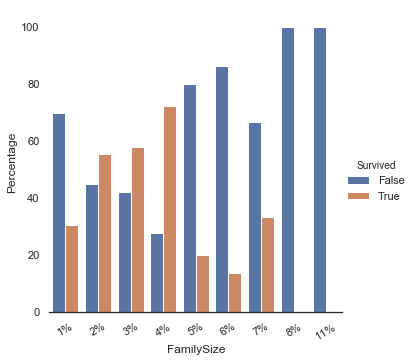

In [25]:
for dataset in combine:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

rel_cat_cat(train_df, 'FamilySize', 'Survived', plot=True)

IsAlone,0,1,0%,1%
Survived,,,,
False,175,374,49.44,69.65
True,179,163,50.56,30.35


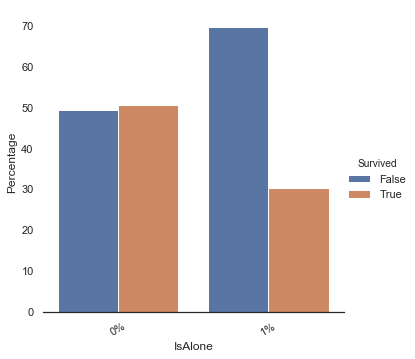

In [26]:
for dataset in combine:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
    
rel_cat_cat(train_df, 'IsAlone', 'Survived', plot=True)

### Drop Ticket, Name, PassengerId, Cabin

In [27]:
for dataset in combine:
    dataset.drop(['Name', 'PassengerId', 'Ticket', 'Cabin'], axis=1, inplace=True)

    display(dataset.head())

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Cabin_number,Cabin_id,Title,FamilySize,IsAlone
0,False,3,male,22.0,1,0,7.2500,S,0,NaN,Mr,2,0
1,True,1,female,38.0,1,0,71.2833,C,1,C,Mrs,2,0
2,True,3,female,26.0,0,0,7.9250,S,0,NaN,Miss,1,1
3,True,1,female,35.0,1,0,53.1000,S,1,C,Mrs,2,0
4,False,3,male,35.0,0,0,8.0500,S,0,NaN,Mr,1,1


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Cabin_number,Cabin_id,Title,FamilySize,IsAlone
0,3,male,34.5,0,0,7.8292,Q,0,NaN,Mr,1,1
1,3,female,47.0,1,0,7.0000,S,0,NaN,Mrs,2,0
2,2,male,62.0,0,0,9.6875,Q,0,NaN,Mr,1,1
3,3,male,27.0,0,0,8.6625,S,0,NaN,Mr,1,1
4,3,female,22.0,1,1,12.2875,S,0,NaN,Mrs,3,0


### Impute Embark

In [28]:
ImputerCategory(
    'Embarked', ['Pclass', 'Sex', 'SibSp', 'Parch', 'Fare', 'Title'],
    imputer='randomforest').fit_transform(train_df).head()

,Embarked
0,S
1,C
2,S
3,S
4,S


### Impute Age

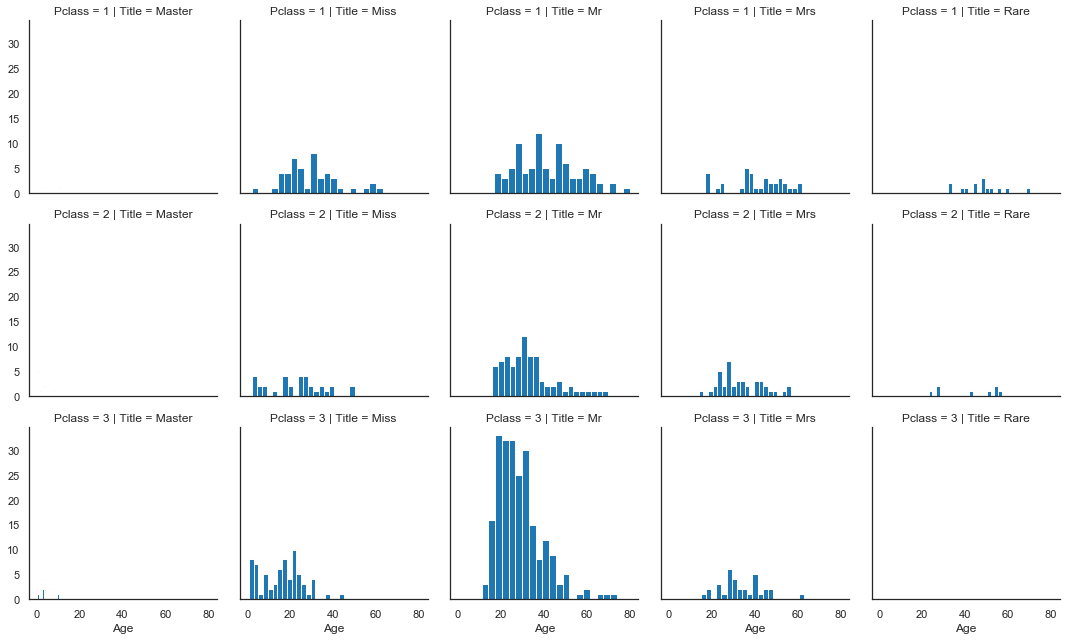

In [29]:
rel_cont_cat_hist(train_df, 'Age', 'Title', 'Pclass')

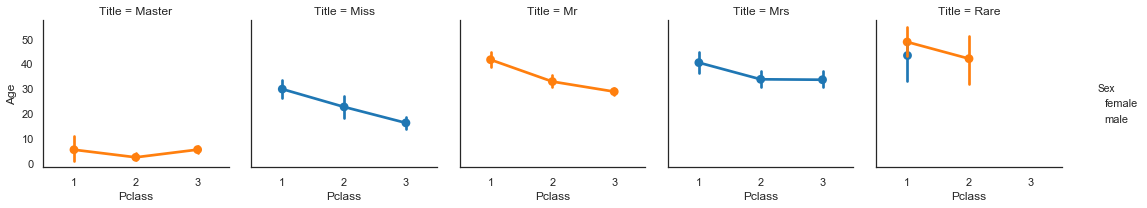

In [30]:
rel_cont_cat_point(train_df, 'Age', 'Pclass', 'Sex', 'Title')

In [31]:
ImputerContinous('Age', ['Pclass', 'Sex', 'SibSp', 'Parch', 'Fare', 'Title'],
          'randomforest').fit_transform(train_df).head() #, 'Embarked'

,Age
0,22.0
1,38.0
2,26.0
3,35.0
4,35.0


### Impute Fare

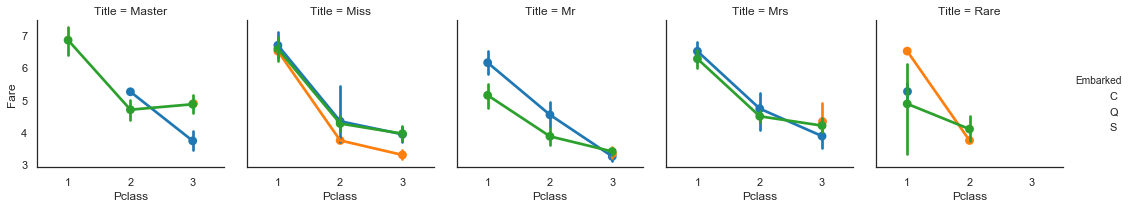

In [32]:
rel_cont_cat_point(train_df, 'Fare', 'Pclass', 'Embarked', 'Title', logtransform=True)

In [33]:
ImputerContinous('Fare', ['Pclass', 'Sex', 'SibSp', 'Parch', 'Title'],
          'randomforest').fit_transform(test_df).head()

,Fare
0,7.8292
1,7.0000
2,9.6875
3,8.6625
4,12.2875


### Binning Age

In [34]:
Age_imputed = ImputerContinous(
    'Age', ['Pclass', 'Sex', 'SibSp', 'Parch', 'Fare', 'Title'],
    'randomforest').fit_transform(train_df)
DF = pd.concat([train_df['Survived'], pd.DataFrame(Age_imputed)], axis=1)
bands = Binning('Age', bins=8, retorders=False).fit_transform(DF)
bands.head()

,Age_Bands,Age_Bands%
"(20.315, 30.263]",307,34.46
"(30.263, 40.21]",207,23.23
"(10.368, 20.315]",129,14.48
"(40.21, 50.158]",107,12.01
"(0.34, 10.368]",72,8.08
"(50.158, 60.105]",47,5.27
"(60.105, 70.052]",17,1.91
"(70.052, 80.0]",5,0.56


,Age_Bands
0,"(20.315, 30.263]"
1,"(30.263, 40.21]"
2,"(20.315, 30.263]"
3,"(30.263, 40.21]"
4,"(30.263, 40.21]"


In [35]:
bands = Binning('Age', 'Survived', bins=10, retorders=False).fit_transform(DF)
bands.head()

Age_Bands,"(0.34, 8.378]","(8.378, 16.336]","(16.336, 24.294]","(24.294, 32.252]","(32.252, 40.21]","(40.21, 48.168]","(48.168, 56.126]","(56.126, 64.084]","(64.084, 72.042]","(72.042, 80.0]","(0.34, 8.378]%","(8.378, 16.336]%","(16.336, 24.294]%","(24.294, 32.252]%","(32.252, 40.21]%","(40.21, 48.168]%","(48.168, 56.126]%","(56.126, 64.084]%","(64.084, 72.042]%","(72.042, 80.0]%"
Survived,,,,,,,,,,,,,,,,,,,,
False,23,30,131,162,90,57,29,17,9,1,4.19,5.46,23.86,29.51,16.39,10.38,5.28,3.10,1.64,0.18
True,39,19,75,87,59,30,23,9,0,1,11.40,5.56,21.93,25.44,17.25,8.77,6.73,2.63,0.00,0.29


,Age_Bands
0,"(16.336, 24.294]"
1,"(32.252, 40.21]"
2,"(24.294, 32.252]"
3,"(32.252, 40.21]"
4,"(32.252, 40.21]"


In [36]:
bands = Binning('Age', 'Survived', bins=8, retorders=False).fit_transform(DF)
bands.head()

Age_Bands,"(0.34, 10.368]","(10.368, 20.315]","(20.315, 30.263]","(30.263, 40.21]","(40.21, 50.158]","(50.158, 60.105]","(60.105, 70.052]","(70.052, 80.0]","(0.34, 10.368]%","(10.368, 20.315]%","(20.315, 30.263]%","(30.263, 40.21]%","(40.21, 50.158]%","(50.158, 60.105]%","(60.105, 70.052]%","(70.052, 80.0]%"
Survived,,,,,,,,,,,,,,,,
False,31,79,197,129,67,29,13,4,5.65,14.39,35.88,23.50,12.2,5.28,2.37,0.73
True,41,50,110,78,40,18,4,1,11.99,14.62,32.16,22.81,11.7,5.26,1.17,0.29


,Age_Bands
0,"(20.315, 30.263]"
1,"(30.263, 40.21]"
2,"(20.315, 30.263]"
3,"(30.263, 40.21]"
4,"(30.263, 40.21]"


### Binning Fare

In [37]:
bands = Binning('Fare', 'Survived', bins=4, retorders=False).fit_transform(train_df)
bands.head()

Fare_Bands,"(-0.512, 128.082]","(128.082, 256.165]","(256.165, 384.247]","(384.247, 512.329]","(-0.512, 128.082]%","(128.082, 256.165]%","(256.165, 384.247]%","(384.247, 512.329]%"
Survived,,,,,,,,
False,539,8,2,0,98.18,1.46,0.36,0.00
True,314,21,4,3,91.81,6.14,1.17,0.88


,Fare_Bands
0,"(-0.512, 128.082]"
1,"(-0.512, 128.082]"
2,"(-0.512, 128.082]"
3,"(-0.512, 128.082]"
4,"(-0.512, 128.082]"


In [38]:
bands = Binning('Fare', 'Survived', bins=8, retorders=False).fit_transform(train_df)
bands.head()

Fare_Bands,"(-0.512, 64.041]","(64.041, 128.082]","(128.082, 192.123]","(192.123, 256.165]","(256.165, 320.206]","(448.288, 512.329]","(-0.512, 64.041]%","(64.041, 128.082]%","(128.082, 192.123]%","(192.123, 256.165]%","(256.165, 320.206]%","(448.288, 512.329]%"
Survived,,,,,,,,,,,,
False,512,27,4,4,2,0,93.26,4.92,0.73,0.73,0.36,0.00
True,261,53,14,7,4,3,76.32,15.50,4.09,2.05,1.17,0.88


,Fare_Bands
0,"(-0.512, 64.041]"
1,"(64.041, 128.082]"
2,"(-0.512, 64.041]"
3,"(-0.512, 64.041]"
4,"(-0.512, 64.041]"


## Multivariate analysis

### cate features vs. Survival

Survived,False,True,False%,True%
Sex,,,,
female,81,233,14.75,68.13
male,468,109,85.25,31.87


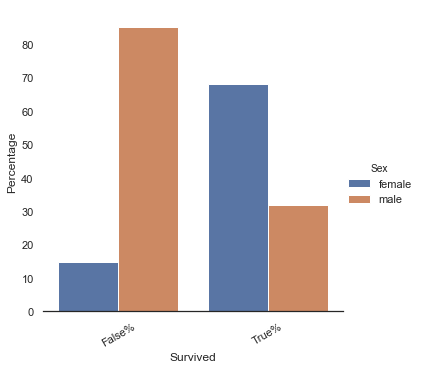

In [39]:
rel_cat_cat(train_df, 'Survived', 'Sex', plot=True)

Sex,female,male,female%,male%
Survived,,,,
False,81,468,25.8,81.11
True,233,109,74.2,18.89


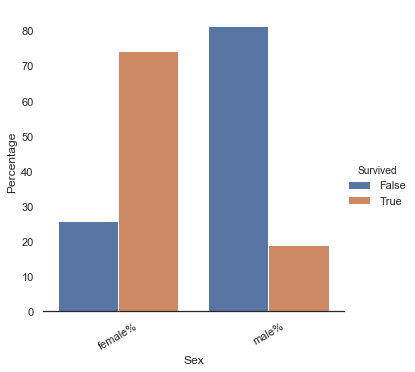

In [40]:
rel_cat_cat(train_df, 'Sex', 'Survived', plot=True)

Survived       False  True  False%  True%
Sex    Pclass                            
female 1           3    91    0.55  26.61
       2           6    70    1.09  20.47
       3          72    72   13.11  21.05
male   1          77    45   14.03  13.16
       2          91    17   16.58   4.97
       3         300    47   54.64  13.74

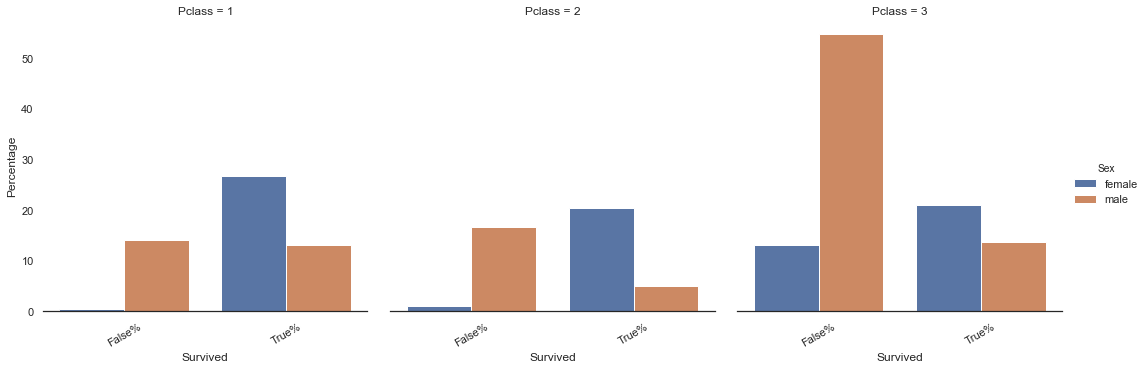

In [41]:
rel_cat_cat(train_df, 'Survived', hue='Sex', col='Pclass', plot=True)

Survived                False  True  False%  True%
Sex    Embarked Pclass                            
female C        1           1    42    0.18  12.35
                2           0     7    0.00   2.06
                3           8    15    1.46   4.41
       Q        1           0     1    0.00   0.29
                2           0     2    0.00   0.59
                3           9    24    1.64   7.06
       S        1           2    46    0.36  13.53
                2           6    61    1.09  17.94
                3          55    33   10.02   9.71
male   C        1          25    17    4.55   5.00
                2           8     2    1.46   0.59
                3          33    10    6.01   2.94
       Q        1           1     0    0.18   0.00
                2           1     0    0.18   0.00
                3          36     3    6.56   0.88
       S        1          51    28    9.29   8.24
                2          82    15   14.94   4.41
                3         231    34   42.08  10.00

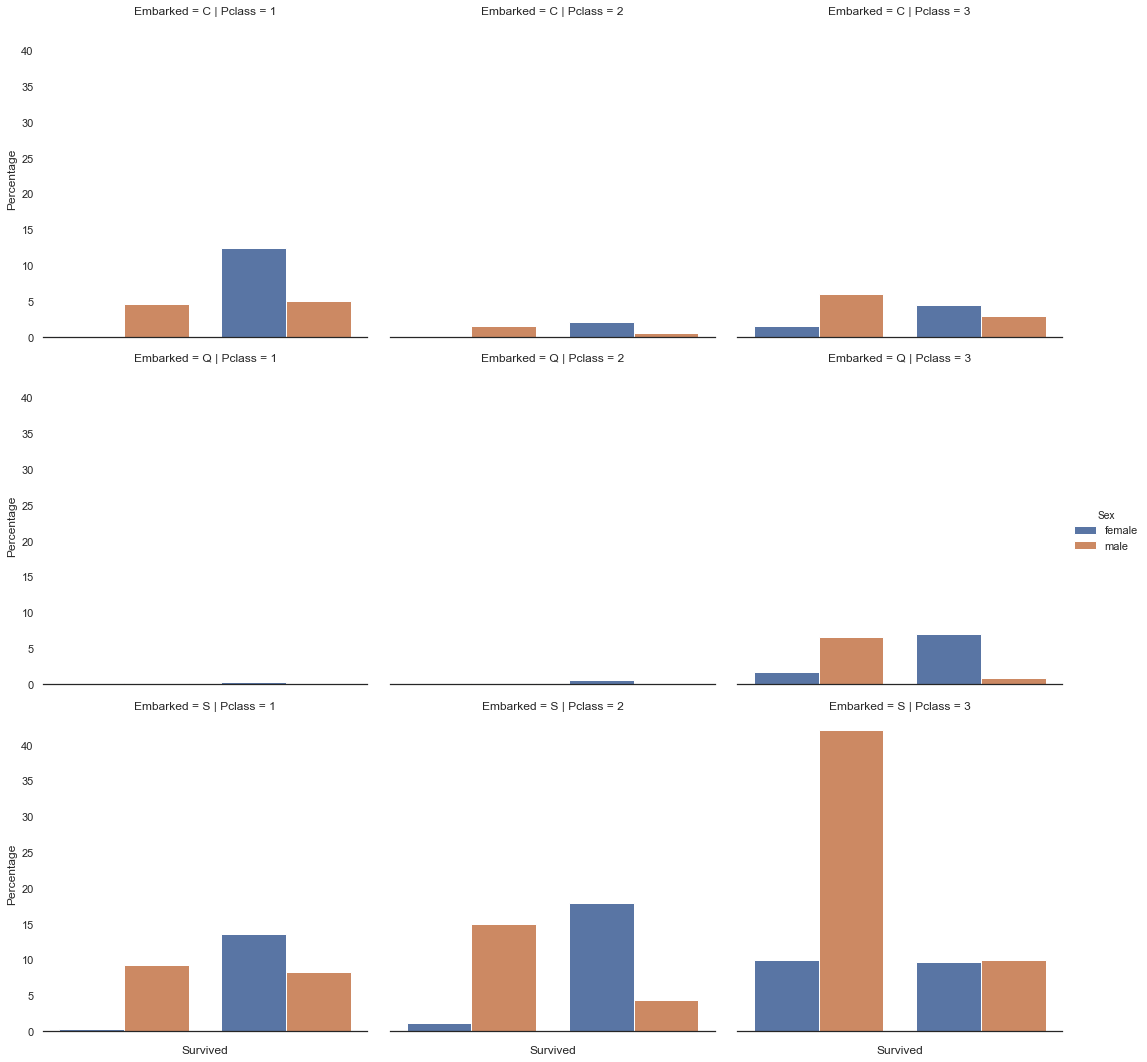

In [42]:
rel_cat_cat(train_df,'Survived','Sex', 'Pclass','Embarked', plot=True)

Survived,False,True,False%,True%
SibSp,,,,
0,398,210,72.50,61.40
1,97,112,17.67,32.75
2,15,13,2.73,3.80
3,12,4,2.19,1.17
4,15,3,2.73,0.88
5,5,0,0.91,0.00
8,7,0,1.28,0.00


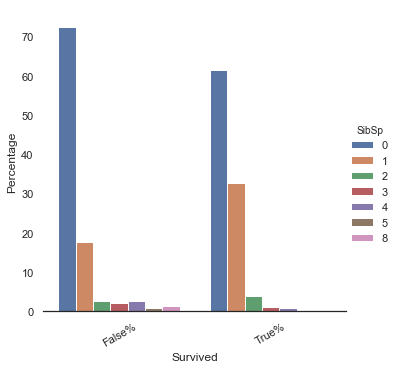

In [43]:
rel_cat_cat(train_df, 'Survived', 'SibSp', plot=True)

Survived,False,True,False%,True%
Parch,,,,
0,445,233,81.06,68.13
1,53,65,9.65,19.01
2,40,40,7.29,11.70
3,2,3,0.36,0.88
4,4,0,0.73,0.00
5,4,1,0.73,0.29
6,1,0,0.18,0.00


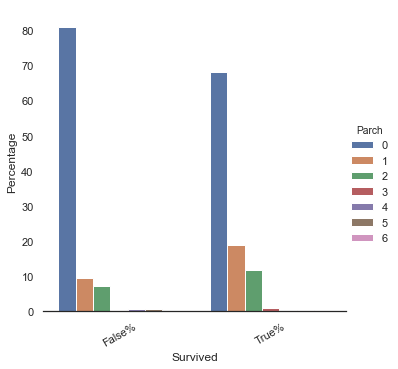

In [44]:
rel_cat_cat(train_df, 'Survived', 'Parch', plot=True)

### cont features vs. Survival

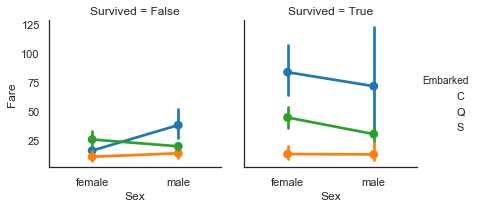

In [45]:
rel_cont_cat_point(train_df, 'Fare', 'Sex', 'Embarked', 'Survived')

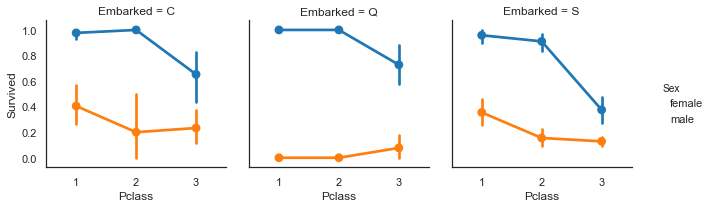

In [46]:
rel_cont_cat_point(train_df, 'Survived', 'Pclass', 'Sex', 'Embarked')

### cont features vs. cont

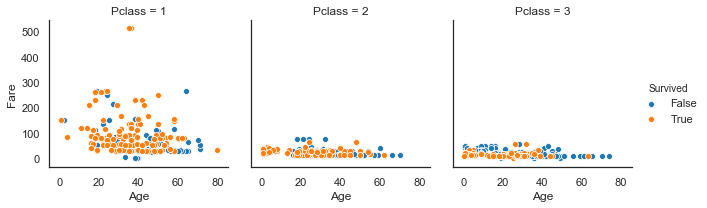

In [47]:
rel_cont_cont_scatter(train_df, 'Fare', 'Age', 'Survived', 'Pclass')

# Preprocessing pipelines

In [48]:
'''
preprocess_pipeline = make_pipeline(
    ColumnSelector(columns=x_cols),
    FeatureUnion(transformer_list=[
        ("numeric_features", make_pipeline(
            TypeSelector(np.number),
            SimpleImputer(strategy="median"),
            StandardScaler()
        )),
        ("categorical_features", make_pipeline(
            TypeSelector("category"),
            SimpleImputer(strategy="most_frequent"),
            OneHotEncoder()
        )),
        ("boolean_features", make_pipeline(
            TypeSelector("bool"),
            SimpleImputer(strategy="most_frequent")
        ))
    ])
)
'''

'\npreprocess_pipeline = make_pipeline(\n    ColumnSelector(columns=x_cols),\n    FeatureUnion(transformer_list=[\n        ("numeric_features", make_pipeline(\n            TypeSelector(np.number),\n            SimpleImputer(strategy="median"),\n            StandardScaler()\n        )),\n        ("categorical_features", make_pipeline(\n            TypeSelector("category"),\n            SimpleImputer(strategy="most_frequent"),\n            OneHotEncoder()\n        )),\n        ("boolean_features", make_pipeline(\n            TypeSelector("bool"),\n            SimpleImputer(strategy="most_frequent")\n        ))\n    ])\n)\n'

In [49]:
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Cabin_number,Cabin_id,Title,FamilySize,IsAlone
0,False,3,male,22.0,1,0,7.2500,S,0,NaN,Mr,2,0
1,True,1,female,38.0,1,0,71.2833,C,1,C,Mrs,2,0
2,True,3,female,26.0,0,0,7.9250,S,0,NaN,Miss,1,1
3,True,1,female,35.0,1,0,53.1000,S,1,C,Mrs,2,0
4,False,3,male,35.0,0,0,8.0500,S,0,NaN,Mr,1,1


In [50]:
#object_columns = train_df.columns[train_df.dtypes == object].tolist()
object_columns = ['Cabin_id']
object_levels = np.union1d(train_df[object_columns].fillna('NAN'),
                           test_df[object_columns].fillna('NAN'))

preprocess_pipeline = DataFrameFeatureUnion([
    make_pipeline(
        ImputerContinous('Age',
                         ['Pclass', 'Sex', 'SibSp', 'Parch', 'Fare', 'Title'],
                         'randomforest'), Binning(
                             'Age', bins=8, retorders=True)),
    make_pipeline(
        ImputerContinous('Age',
                         ['Pclass', 'Sex', 'SibSp', 'Parch', 'Fare', 'Title'],
                         'randomforest'), DataFrameStandardScaler()),
    Binning('Fare', bins=8, retorders=True),
    make_pipeline(
        ColumnSelector(columns=['Fare']),
        DataFrameStandardScaler()),
    make_pipeline(
        DataFrameFeatureUnion([
            ColumnSelector(columns=['Sex', 'Title']),
            make_pipeline(
                ImputerCategory(
                    'Embarked',
                    ['Pclass', 'Sex', 'SibSp', 'Parch', 'Fare', 'Title'],
                    imputer='randomforest')),
            make_pipeline(
                ColumnSelector(columns=['Cabin_id']),
                DataFrameFunction(lambda x: 'NAN', impute=True),
                DataFrameFunction(
                    lambda x: x.astype(pd.api.types.CategoricalDtype(categories = object_levels))))
        ]), ToDummies()),
    ColumnSelector(columns=[
        'Pclass', 'SibSp', 'Parch', 'Cabin_number', 'FamilySize', 'IsAlone'
    ])
])

In [51]:
preprocessed_train = preprocess_pipeline.fit_transform(train_df)

,Age_Bands,Age_Bands%
"(20.315, 30.263]",307,34.46
"(30.263, 40.21]",207,23.23
"(10.368, 20.315]",129,14.48
"(40.21, 50.158]",107,12.01
"(0.34, 10.368]",72,8.08
"(50.158, 60.105]",47,5.27
"(60.105, 70.052]",17,1.91
"(70.052, 80.0]",5,0.56


,Fare_Bands,Fare_Bands%
"(-0.512, 64.041]",773,86.76
"(64.041, 128.082]",80,8.98
"(128.082, 192.123]",18,2.02
"(192.123, 256.165]",11,1.23
"(256.165, 320.206]",6,0.67
"(448.288, 512.329]",3,0.34
"(384.247, 448.288]",0,0.00
"(320.206, 384.247]",0,0.00


In [52]:
preprocessed_train.head()

,Age_BandsOrder,Age,Fare_BandsOrder,Fare,Sex_female,Sex_male,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Embarked_C,Embarked_Q,Embarked_S,Cabin_id_A,Cabin_id_B,Cabin_id_C,Cabin_id_D,Cabin_id_E,Cabin_id_F,Cabin_id_G,Cabin_id_NAN,Cabin_id_T,Pclass,SibSp,Parch,Cabin_number,FamilySize,IsAlone
0,2,-0.556103,0,-0.502445,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,3,1,0,0,2,0
1,3,0.607909,1,0.786845,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,1,2,0
2,2,-0.265100,0,-0.488854,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,3,0,0,0,1,1
3,3,0.389656,0,0.420730,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,1,2,0
4,3,0.389656,0,-0.486337,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,3,0,0,0,1,1


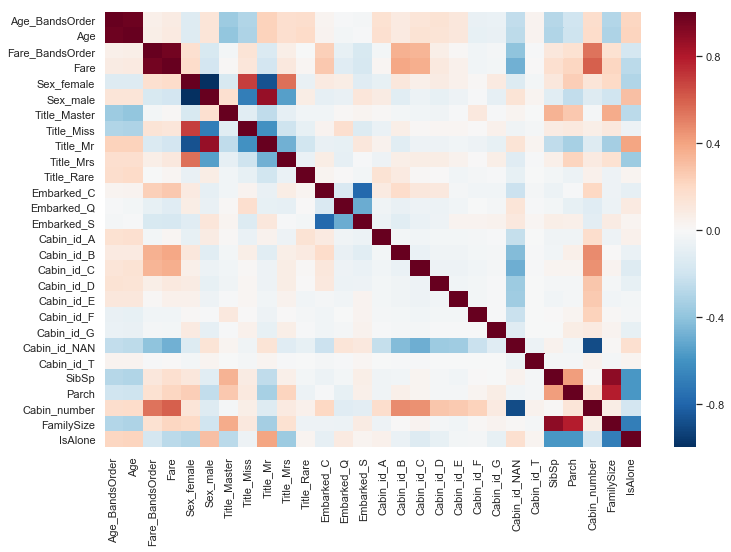

In [53]:
plt.figure(figsize=(12, 8))
sns.heatmap(
    preprocessed_train.corr(),
    annot=False,
    center=0,
    vmin=-1,
    vmax=1,
    cmap='RdBu_r',
    linecolor='white')

[0.40248563 0.23257033]


,PC1,PC2,target
0,0.5,-1.0,False
1,-0.0,2.1,True
2,-0.6,-1.3,True
3,-0.0,1.5,True
4,-1.4,-0.6,False


,PC1,PC2,featurenames,type
0,-0.4,0.6,Age_BandsOrder,Age
1,-0.3,0.4,Age,Age
2,0.0,0.2,Fare_BandsOrder,Fare
3,0.1,0.4,Fare,Fare
4,0.1,0.0,Sex_female,Sex


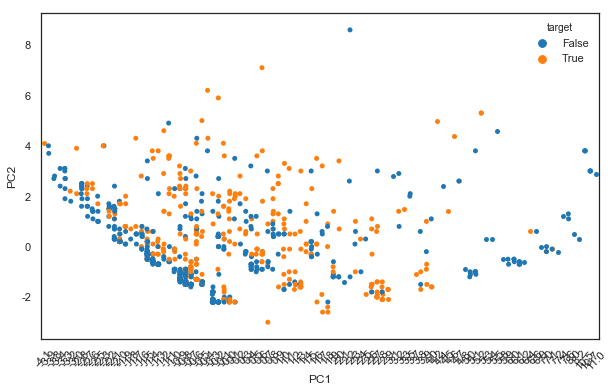

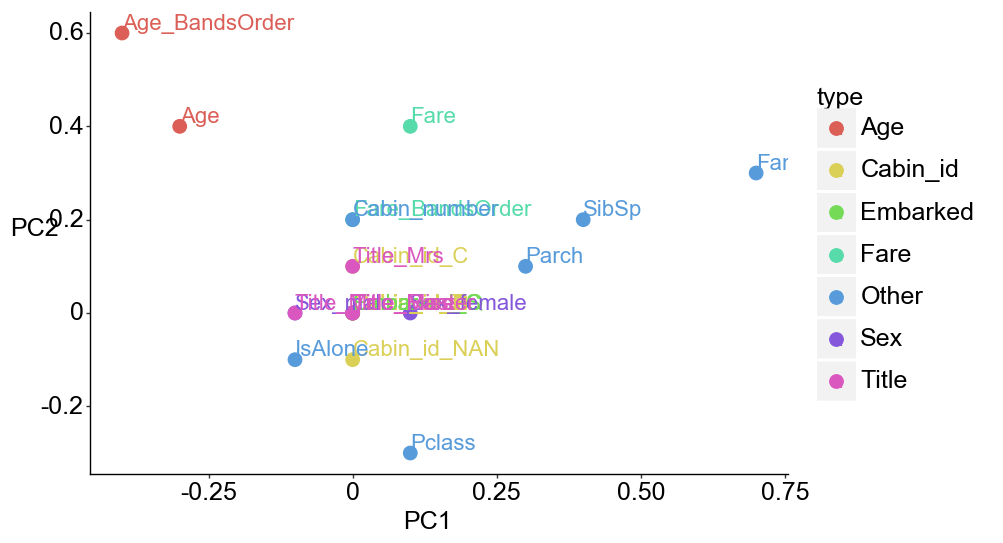

<ggplot: (-9223372029309897500)>

In [54]:
feature_types = ['Age']*2 + ['Fare']*2 + ['Sex'] * 2 + ['Title'] * 5 + [
    'Embarked'
] * 3 + ['Cabin_id'] * 9 + ['Other'] * 6
components = PCA_exploration(preprocessed_train, train_df[['Survived']].values,
                             feature_types)

# Classifier

In [172]:
X = preprocessed_train
y = train_df['Survived']

#train_X, test_X, train_y, test_y = train_test_split(
#    X, y, test_size=0.25, random_state=33)
train_X = X
train_y = y
print("Size of train:", train_X.shape)
print("Size of test:", test_X.shape)

cv = StratifiedKFold(n_splits=6)

Size of train: (891, 29)
Size of test: (223, 29)


## LogisticRegression

In [138]:
lr = LogisticRegression(multi_class='auto', solver='lbfgs', max_iter=1000)
lr.fit(train_X, train_y)
## 查看系数
coefficients = pd.DataFrame(
    lr.coef_.T.round(2), index=train_X.columns,
    columns=['coefficients']).sort_values(
        by='coefficients', ascending=False)
display(coefficients)
print(u'Accuracy with cross-validation is %.4lf' % np.median(
    cross_val_score(lr, train_X, train_y, cv=10)))

,coefficients
Title_Master,1.47
Fare,0.78
Title_Mrs,0.77
Sex_female,0.74
Cabin_id_E,0.71
Cabin_id_D,0.44
Cabin_id_F,0.20
Embarked_C,0.18
Cabin_id_A,0.16
Cabin_id_B,0.09


Accuracy with cross-validation is 0.8182


(0.7956030117150521, 0.07879445139503256)

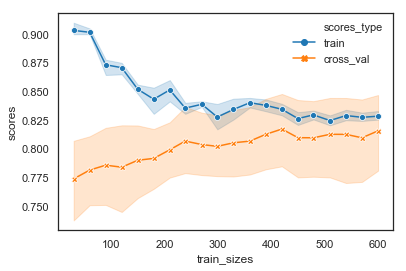

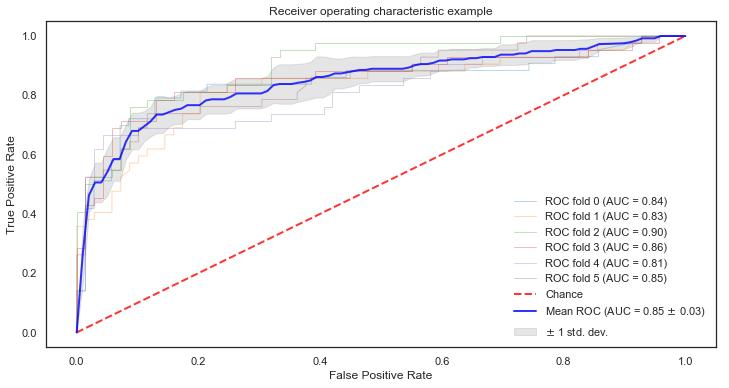

In [139]:
display(plot_learning_curve(lr, u"Learning curve", train_X, train_y, cv=10))
plot_ROC_curve(lr, cv, train_X.values, train_y.values)

## DecisionTreeClassifier

In [173]:
dt = tree.DecisionTreeClassifier()
dt.fit(train_X, train_y)
display(
    pd.DataFrame(
        dt.feature_importances_,
        index=train_X.columns,
        columns=['feature_importances']).sort_values(
            by='feature_importances', ascending=False))

,feature_importances
Title_Mr,0.311877
Fare,0.209438
Age,0.204116
FamilySize,0.085115
Pclass,0.049520
Title_Rare,0.028321
Age_BandsOrder,0.020954
Parch,0.013795
SibSp,0.013635
Cabin_number,0.009473


Accuracy with cross-validation is 0.7877


(0.8671220105650487, 0.24543014068944935)

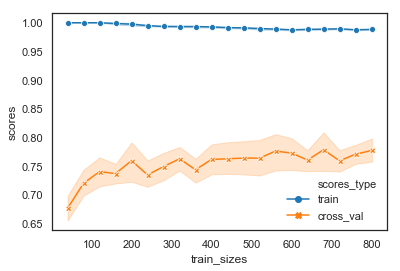

In [198]:
print(u'Accuracy with cross-validation is %.4lf' % np.median(
    cross_val_score(dt, train_X, train_y, cv=10)))
display(plot_learning_curve(dt, u"Learning curve", train_X, train_y, cv=10))
#plot_ROC_curve(dt, cv, train_X.values, train_y.values)

In [201]:
# Create the random grid
param_grid = {
    #'n_estimators': [int(x) for x in np.linspace(start=200, stop=2000, num=10)],
    'max_features': [None, 'sqrt', 'log2'],
    'max_depth': [int(x) for x in np.linspace(10, 110, num=11)] + [None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': np.arange(1,100,10)
}
display(param_grid)

# 使用 RandomizedSearchCV 进行参数调优
dt_random = RandomizedSearchCV(
    estimator=dt,
    param_distributions=param_grid,
    n_iter=100,
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1)
dt_random.fit(train_X, train_y)
print(" 最优分数： %.4lf" % dt_random.best_score_)
print(" 最优参数：")
display(dt_random.best_params_)

{'max_features': [None, 'sqrt', 'log2'],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': array([ 1, 11, 21, 31, 41, 51, 61, 71, 81, 91])}

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    1.1s


 最优分数： 0.8126
 最优参数：


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    4.9s finished
/Users/mymac/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'min_samples_split': 2,
 'min_samples_leaf': 41,
 'max_features': None,
 'max_depth': 110}

Accuracy with cross-validation is 0.8202


(0.8052097730034037, 0.03458192258025705)

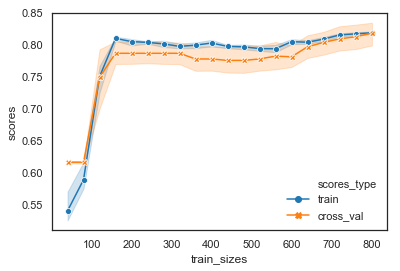

In [202]:
print(u'Accuracy with cross-validation is %.4lf' % np.median(
    cross_val_score(dt_random.best_estimator_, train_X, train_y, cv=10)))
display(plot_learning_curve(dt_best, u"Learning curve", X, y, cv=10))
#plot_ROC_curve(dt_best, cv, X.values, y.values)

In [204]:
param_grid = {
    #'n_estimators': [int(x) for x in np.linspace(start=200, stop=2000, num=10)],
    'max_features': [None, 'sqrt'],
    'max_depth': [100, 110, 120],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': np.arange(30,50,5)
}

# 使用 GridSearchCV 进行参数调优
dt_gird = GridSearchCV(estimator=dt, param_grid=param_grid, cv=10, iid=False)
dt_gird.fit(X, y)
print(" 最优分数： %.4lf" %dt_gird.best_score_)
print(" 最优参数：")
display(dt_random.best_params_)

 最优分数： 0.8171
 最优参数： {'max_depth': 100, 'max_features': None, 'min_samples_leaf': 45, 'min_samples_split': 2}


Accuracy with cross-validation is 0.8202


(0.8098086725264544, 0.029116300219566463)

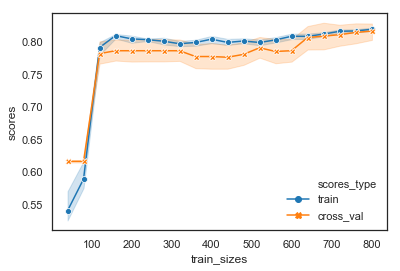

In [205]:
print(u'Accuracy with cross-validation is %.4lf' % np.median(
    cross_val_score(dt_gird.best_estimator_, train_X, train_y, cv=10)))
display(plot_learning_curve(dt_gird.best_estimator_, u"Learning curve", X, y, cv=10))
#plot_ROC_curve(dt_gird.best_estimator_, cv, X.values, y.values)